In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('data_output/charting_clean.csv', low_memory=False)

In [3]:
df_exploded = pd.read_csv('data_output/df_exploded_full.csv', low_memory=False)

In [4]:
df_exploded.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts
0,Novak Djokovic,6,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
1,Ben Shelton,f2n#,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
2,Novak Djokovic,4n,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
3,Novak Djokovic,6 f1 s1 f2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
4,Ben Shelton,b19 b2 f3 j2*,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0


# Clasificacion de Rallies
El objetivo del modelo es clasificar los rallies en tres categorías: agresivo, donde el jugador toma la iniciativa **clara** de ganar el punto (independientemente de si lo logra o no), seguro (puntos de pocos riesgos, extensos, buscando que el rival cometa un error) y convencionales (puntos comunes, poco destacados). Para ello, se utilizará un modelo de clustering basado en K-Means.
 Lo destacable de este proceso no es el modelo de clustering en si sino la creacion de los parametros que se utilizaran para clasificar los rallies, porque una secuencia de golpes no es un dato que se pueda utilizar directamente en un modelo de clustering.

## Creación de parametros
Ponemos un minimo de 3 golpes por rally. Si fuera menos, no se podria clasificar, y habria un cluster enorme dedicado a puntos de simplemente saque devolución.

In [5]:
#Filtro de rallies con menos de 3 golpes
df_exploded = df_exploded[df_exploded['Sequence'].apply(lambda x: len(x.split())) >= 3].reset_index(drop=True)
df_exploded.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts
0,Novak Djokovic,6 f1 s1 f2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
1,Ben Shelton,b19 b2 f3 j2*,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
2,Novak Djokovic,4 b2 b1 b3 f2 f1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,11,0,0,1.0,1.0,0-0
3,Ben Shelton,b28 f2 s3 f1 b1 b3n@,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,11,0,0,1.0,1.0,0-0
4,Ben Shelton,6 f2 f3d@,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,19,0,0,2.0,1.0,40-15


La extracción de características se realizará a partir de la secuencia de golpes de cada rally. Se contabilizarán los diferentes tipos de golpes y se calcularán las proporciones de cada uno de ellos. Además, se aplicarán pesos a las proporciones para influir en los clusters.

In [6]:
def extract_features_with_weights(sequence):
    # Diccionario para contar diferentes tipos de golpes
    counts = {
        "num_shots": 0,
        "num_corners": 0,
        "num_middle": 0,
        "num_forehand": 0,
        "num_backhand": 0,
        "num_groundstrokes": 0,
        "num_smash": 0,
        "num_volley": 0,
        "num_drop": 0,
        "num_lob": 0,
        "num_slice": 0
    }

    # Recorrer cada carácter en la secuencia
    for token in sequence.split():
        counts["num_shots"] += 1

        if '1' in token or '3' in token:
            counts["num_corners"] += 1
        if '2' in token:
            counts["num_middle"] += 1
        if 'f' in token:
            counts["num_forehand"] += 1
        if 'b' in token:
            counts["num_backhand"] += 1
        if 'f' in token or 'b' in token:  # Agrupa forehand y backhand
            counts["num_groundstrokes"] += 1
        if 's' in token or 'r' in token:
            counts["num_slice"] += 1
        if 'p' in token or 'o' in token:
            counts["num_smash"] += 1
        if any(c in token for c in 'vzhiqjk'):
            counts["num_volley"] += 1
        if 'u' in token or 'y' in token:
            counts["num_drop"] += 1
        if 'l' in token or 'm' in token:
            counts["num_lob"] += 1

    # Calcular proporciones
    total_shots = counts["num_shots"]
    if total_shots > 0:
        props = {
            "corners": counts["num_corners"] / total_shots,
            "middle": counts["num_middle"] / total_shots,
            "groundstrokes": counts["num_groundstrokes"] / total_shots,
            "forehand": counts["num_forehand"] / total_shots,
            "backhand": counts["num_backhand"] / total_shots,
            "slice": counts["num_slice"] / total_shots,
            "smash": counts["num_smash"] / total_shots,
            "volley": counts["num_volley"] / total_shots,
            "drop": counts["num_drop"] / total_shots,
            "lob": counts["num_lob"] / total_shots,
        }
    else:
        props = {key: 0 for key in counts.keys()}

    # Aplicar pesos para influir en los clusters
    features = {
        "neutral_weighted": (props["forehand"] + props["backhand"] + props["groundstrokes"] + props["middle"]) * 1.5,
        "defensive_weighted": (props["lob"] + props["drop"] + props["slice"] + (1 / total_shots if total_shots > 0 else 0)) * 2,
        "aggressive_weighted": (props["smash"] + props["volley"]) * 2.5,
    }

    return [
        #add number of shots
        counts["num_shots"],
        props["corners"],
        props["middle"],
        props["forehand"],
        props["backhand"],
        props["groundstrokes"],
        props["slice"],
        props["smash"],
        props["volley"],
        props["drop"],
        props["lob"],
        features["neutral_weighted"],
        features["defensive_weighted"],
        features["aggressive_weighted"],
    ]

# Aplicar la función al DataFrame
df_features = df_exploded['Sequence'].apply(extract_features_with_weights).tolist()

# Crear el DataFrame con todas las características
columns = [
    "num_shots",
    "corners", 
    "middle",
    "forehand", 
    "backhand",
    "groundstrokes",
    "slice",
    "smash", 
    "volley", 
    "drop", 
    "lob", 
    "neutral", 
    "defensive", 
    "aggressive"
]

df_features = pd.DataFrame(df_features, columns=columns)

df_features.sample(3)

,num_shots,corners,middle,forehand,backhand,groundstrokes,slice,smash,volley,drop,lob,neutral,defensive,aggressive
228993,4,0.750000,0.000000,0.5,0.250000,0.750000,0.000000,0.000000,0.0,0.0,0.0,2.25,0.500000,0.000000
299448,3,0.000000,0.666667,0.0,0.666667,0.666667,0.000000,0.000000,0.0,0.0,0.0,3.00,0.666667,0.000000
20039,3,0.666667,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.0,0.0,0.00,1.333333,0.833333


In [7]:
#copia de testeo
features_df = df_features.copy()
#features_df = features_df.drop(columns=['num_shots'])
#features_df = features_df.drop(columns=['slice'])

In [8]:
"""#apply min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features_df)"""

'#apply min max scaler\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\nfeatures_normalized = scaler.fit_transform(features_df)'

In [9]:
#Use standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_df)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Aplicar K-Means con 3 clusters (agresivo, defensivo, neutral)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_normalized)

C:\Users\agusd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [31]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pandas as pd

# Updated code excluding DBSCAN
# Gaussian Mixture
gaussian = GaussianMixture(n_components=3, random_state=42)
gaussian_labels = gaussian.fit_predict(features_normalized)

sample_indices = np.random.choice(range(features_normalized.shape[0]), size=30000, replace=False)
sample_features = features_normalized[sample_indices]
sample_labels = kmeans.labels_[sample_indices]
sample_labels_gaussian = gaussian_labels[sample_indices]

# Calculate Silhouette Score for KMeans and Gaussian Mixture
kmeans_silhouette = silhouette_score(sample_features, sample_labels)
gaussian_silhouette = silhouette_score(sample_features, sample_labels_gaussian)


# Calculate Inertia for KMeans and Gaussian Mixture
kmeans_inertia = kmeans.inertia_
gaussian_inertia = gaussian.lower_bound_  # Approximation for Gaussian Mixture

# Create comparison table without DBSCAN
comparison_data = {
    "Model": ["KMeans", "Gaussian Mixture"],
    "Silhouette Score": [kmeans_silhouette, gaussian_silhouette],
    "Inertia/Lower Bound": [kmeans_inertia, gaussian_inertia],
    "Number of Clusters": [len(set(kmeans.labels_)), len(set(gaussian_labels))],
}

comparison_df = pd.DataFrame(comparison_data)

In [32]:
comparison_df

,Model,Silhouette Score,Inertia/Lower Bound,Number of Clusters
0,KMeans,0.297761,4.730590e+06,3
1,Gaussian Mixture,0.313022,3.139038e+01,3


In [33]:
features_df['cluster'] = kmeans.labels_
features_df['cluster_gaussian'] = gaussian_labels

# Clasificacion

In [36]:
df_exploded['cluster'] = features_df['cluster']
df_exploded['cluster_gaussian'] = features_df['cluster_gaussian']

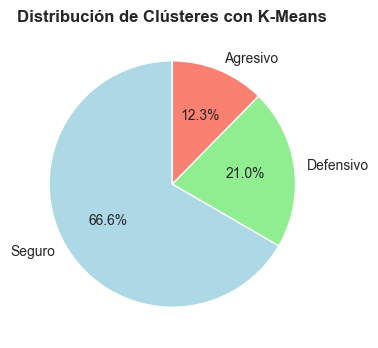

In [222]:
import matplotlib.pyplot as plt

# Contar y normalizar la distribución de los clusters
cluster_distribution = df_exploded['cluster'].value_counts(normalize=True)

# Mapeo de etiquetas
labels = {
    1: "Seguro",
    0: "Defensivo",
    2: "Agresivo"
}

# Etiquetas actualizadas para el gráfico
updated_labels = [labels[cluster] for cluster in cluster_distribution.index]

# Pie plot
plt.figure(figsize=(4, 4))
plt.pie(cluster_distribution, labels=updated_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'salmon'])
plt.title("Distribución de Clústeres con K-Means", fontweight='bold')

plt.savefig('viz_outputs/cluster_distribution_kmeans.png')
plt.show()

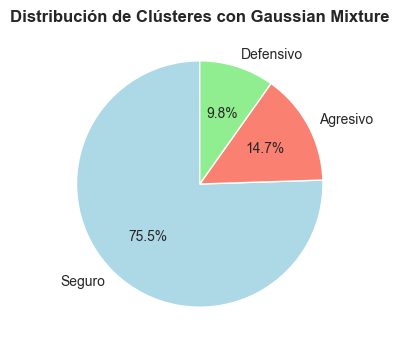

In [97]:
# Contar y normalizar la distribución de los clusters para Gaussian Mixture
cluster_gaussian_distribution = df_exploded['cluster_gaussian'].value_counts(normalize=True)

# Mapeo de etiquetas para Gaussian Mixture
gaussian_labels = {
    2: "Seguro",
    0: "Agresivo",
    1: "Defensivo"
}

# Etiquetas actualizadas para el gráfico
updated_gaussian_labels = [gaussian_labels[cluster] for cluster in cluster_gaussian_distribution.index]

# Pie plot para Gaussian Mixture
plt.figure(figsize=(4, 4))
plt.pie(cluster_gaussian_distribution, labels=updated_gaussian_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon', 'lightgreen'])
plt.title("Distribución de Clústeres con Gaussian Mixture", fontweight='bold')

plt.savefig('viz_outputs/cluster_distribution_gaussian.png')
plt.show()


In [468]:
#df_exploded.to_csv('data_output/df_exploded_clustered.csv', index=False)

# Conclusiones

In [469]:
cluster_centers = kmeans.cluster_centers_
centroid_df = pd.DataFrame(cluster_centers, columns=features_df.columns[:-1])
centroid_df

,num_shots,corners,middle,forehand,backhand,groundstrokes,slice,smash,volley,drop,lob,neutral,defensive,aggressive
0,-0.241164,-0.168574,0.291024,-0.527699,-0.368489,-0.867530,1.429567,-0.185446,-0.302801,0.417092,0.608158,-0.624617,1.575810,-0.340666
1,0.169660,0.032771,0.005812,0.294525,0.270759,0.548308,-0.378013,-0.178372,-0.298446,-0.134130,-0.165986,0.471731,-0.471462,-0.333964
2,-0.505222,0.110140,-0.526927,-0.691373,-0.834181,-1.482713,-0.393623,1.278683,2.126706,0.013855,-0.139522,-1.482956,-0.138176,2.382919


In [470]:
df_exploded[df_exploded['cluster'] == 1].sample(3)

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,cluster
74468,Felix Auger Aliassime,6 b3 f3,20220628-M-Wimbledon-R128-Maxime_Cressy-Felix_...,297,2,1,6.0,5.0,40-40,1
22689,Daniil Medvedev,b28 f1 f3 b2 b3 b2,20230413-M-Monte_Carlo_Masters-R16-Alexander_Z...,152,1,1,2.0,3.0,15-0,1
324912,Gilles Simon,b29 b1 f1,20121103-M-Paris_Masters-SF-Gilles_Simon-Jerzy...,31,0,0,2.0,3.0,15-15,1


Vemos que el cluster 1 es el más común, ademas si ponemos foco en sus secuencias, estas estan compuestas por golpes habituales. Son en su mayoria golpes de fondo de, reves y drive y esquinados.

In [471]:
df_exploded[df_exploded['cluster'] == 0].sample(3)

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,cluster
320579,Fabio Fognini,b28 f3 s3 s1,20130419-M-Monte_Carlo_Masters-SF-Novak_Djokov...,30,0,0,3.0,1.0,30-15,0
452535,Pete Sampras,4 s1 f3*,19950910-M-US_Open-F-Pete_Sampras-Andre_Agassi,188,2,1,0.0,1.0,40-30,0
424799,Pete Sampras,s29 f3 s2 b3 s2 f1 b3 b1,20010906-M-US_Open-QF-Pete_Sampras-Andre_Agassi,258,2,1,0.0,0.0,15-30,0


El cluster 0 es menos comun. Se caracteriza por golpes mas conservadores, como slices, drops y lobs, al centro de la cancha. Este cluster es el mas defensivo o seguro.

In [472]:
df_exploded[df_exploded['cluster'] == 2].sample(3)

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,cluster
381423,Fernando Gonzalez,6 f3 f1 o3*,20070123-M-Australian_Open-QF-Rafael_Nadal-Fer...,57,0,1,0.0,1.0,15-30,2
441530,Goran Ivanisevic,6 v3 z2n#,19980704-M-Wimbledon-SF-Goran_Ivanisevic-Richa...,234,2,1,5.0,6.0,30-0,2
495147,John Mcenroe,4 f1 z3,19840908-M-US_Open-SF-John_Mcenroe-Jimmy_Connors,223,2,1,1.0,3.0,15-30,2


El cluster 2 es el menos comun. Se caracteriza por golpes mas definitorios, como voleas y smashes. Este cluster es el mas agresivo.

In [100]:
safe_mean_rally_length_k = df_exploded[df_exploded['cluster'] == 1]['Sequence'].apply(lambda x: len(x.split())).mean()
defensive_mean_rally_length_k = df_exploded[df_exploded['cluster'] == 0]['Sequence'].apply(lambda x: len(x.split())).mean()
agressive_mean_rally_length_k = df_exploded[df_exploded['cluster'] == 2]['Sequence'].apply(lambda x: len(x.split())).mean()

print(f"Longitud media de rallies seguros: {safe_mean_rally_length_k}"
      f"\nLongitud media de rallies defensivos: {defensive_mean_rally_length_k}"
      f"\nLongitud media de rallies agresivos: {agressive_mean_rally_length_k}")

Longitud media de rallies seguros: 4.911577575975705
Longitud media de rallies defensivos: 4.052882212603845
Longitud media de rallies agresivos: 3.501107757513486


Logicamente los rallies mas largos son los del cluster 1, ya que son los mas comunes convencionales y los mas cortos son los del cluster 2, ya que buscan cerrar el punto (ya sea con winner o error).

# Comparación de Modelos

In [84]:
safe_mean_rally_length_g = df_exploded[df_exploded['cluster_gaussian'] == 2]['Sequence'].apply(lambda x: len(x.split())).mean()
agressive_mean_rally_length_g = df_exploded[df_exploded['cluster_gaussian'] == 0]['Sequence'].apply(lambda x: len(x.split())).mean()
defensive_mean_rally_length_g = df_exploded[df_exploded['cluster_gaussian'] == 1]['Sequence'].apply(lambda x: len(x.split())).mean()

In [106]:
model_comparison_df = {
    'model': ['KMeans', 'Gaussian Mixture'],
    'silloutte_score': [round(kmeans_silhouette,2), round(gaussian_silhouette,2)],
    'agressive_mean_rally_length': [round(agressive_mean_rally_length_k,2), round(agressive_mean_rally_length_g,2)],
    'defensive_mean_rally_length': [round(defensive_mean_rally_length_k,2), round(defensive_mean_rally_length_g,2)],
    'safe_mean_rally_length': [round(safe_mean_rally_length_k,2), round(safe_mean_rally_length_g,2)],
}

model_comparison_df = pd.DataFrame(model_comparison_df)
model_comparison_df

,model,silloutte_score,agressive_mean_rally_length,defensive_mean_rally_length,safe_mean_rally_length
0,KMeans,0.30,3.50,4.05,4.91
1,Gaussian Mixture,0.31,3.97,5.27,4.58


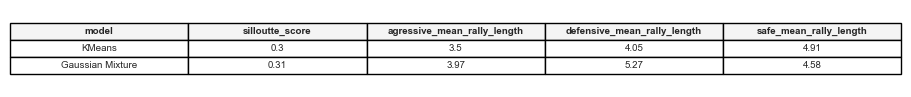

In [221]:
import matplotlib.pyplot as plt

# Configuración de la tabla
fig, ax = plt.subplots(figsize=(5, 1))  # Ajusta el tamaño general de la tabla
ax.axis('tight')
ax.axis('off')

# Crear la tabla con ajustes en las celdas
table = ax.table(
    cellText=model_comparison_df.values,
    colLabels=model_comparison_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.46] * len(model_comparison_df.columns)  # Reducir el ancho de las celdas
)

# Establecer estilo para las cabeceras y valores
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Cabecera
        cell.set_text_props(weight='bold', fontsize=15)  # Texto en negrita y más grande
        cell.set_facecolor('#f4f4f4')  # Fondo claro opcional
    else:  # Celdas de datos
        cell.set_fontsize(12)  # Valores más grandes

# Guardar como imagen
plt.savefig('viz_outputs/df_clusters_comparison_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()


Con un rendimiento similar en el coeficiente de silueta, por una cuestion de interpretacion de los clusters, se eligio el modelo KMeans, que parece tener mayor utilidad sobretodo en la exigencia de la clusterizacion de los rallies agresivos.

In [226]:
import pandas as pd

golpes_totales_agresivos = df_exploded[df_exploded['cluster'] == 2]['Sequence'].str.split().str.len().sum()
golpes_totales_seguros = df_exploded[df_exploded['cluster'] == 1]['Sequence'].str.split().str.len().sum()
golpes_totales_defensivos = df_exploded[df_exploded['cluster'] == 0]['Sequence'].str.split().str.len().sum()

# Contar la aparición de cada carácter en "Sequence"
characters = ['v', 'z', 'o', 'p', 'f', 'b', 's', 'r', 'l', 'm']
char_counts_agressive = {char: df_exploded[df_exploded['cluster'] == 2]['Sequence'].str.count(char).sum() for char in characters}
char_counts_safe = {char: df_exploded[df_exploded['cluster'] == 1]['Sequence'].str.count(char).sum() for char in characters}
char_counts_defensive = {char: df_exploded[df_exploded['cluster'] == 0]['Sequence'].str.count(char).sum() for char in characters}

# Convertir los resultados en un DataFrame para mayor claridad
char_counts_df = pd.DataFrame(list(char_counts_agressive.items()), columns=["Character", "Count_aggressive"])
#append safe
char_counts_df['Count_safe'] = list(char_counts_safe.values())
#append defensive
char_counts_df['Count_defensive'] = list(char_counts_defensive.values())

code_dict = {
    "f": "Golpe de derecha",
    "b": "Golpe de revés",
    "r": "Slice de derecha",
    "s": "Slice de revés",
    "v": "Volea de derecha",
    "z": "Volea de revés",
    "o": "Smash",
    "p": "Smash de revés",
    "u": "Drop shot de derecha",
    "y": "Drop shot de revés",
    "t": "Golpe de fantasía",
    "q": "Golpe desconocido",
    "l": "Globo de derecha",
    "m": "Globo de revés",
    "h": "Media volea de derecha",
    "i": "Media volea de revés",
    "j": "Volea swing de derecha",
    "k": "Volea swing de revés",
}

# reemplazar por golpes 
char_counts_df["Character"] = char_counts_df["Character"].replace(code_dict)

In [227]:
char_counts_df

,Character,Count_aggressive,Count_safe,Count_defensive
0,Volea de derecha,28523,5532,1343
1,Volea de revés,30565,5954,1437
2,Smash,18278,3498,602
3,Smash de revés,1583,254,122
4,Golpe de derecha,47911,742098,110232
5,Golpe de revés,19674,611936,86186
6,Slice de revés,6281,61563,121484
7,Slice de derecha,1429,14053,28965
8,Globo de derecha,463,1701,7766
9,Globo de revés,521,3063,12397


In [228]:
# divide each column by each cluster total shots
char_counts_df['Count_aggressive_pct'] = round(char_counts_df['Count_aggressive'] / golpes_totales_agresivos *100,2)
char_counts_df['Count_safe_pct'] = round(char_counts_df['Count_safe'] / golpes_totales_seguros *100,2)
char_counts_df['Count_defensive_pct'] = round(char_counts_df['Count_defensive'] / golpes_totales_defensivos *100,2)

char_counts_df[['Character', 'Count_aggressive_pct', 'Count_safe_pct', 'Count_defensive_pct']]

,Character,Count_aggressive_pct,Count_safe_pct,Count_defensive_pct
0,Volea de derecha,13.08,0.34,0.31
1,Volea de revés,14.02,0.36,0.33
2,Smash,8.38,0.21,0.14
3,Smash de revés,0.73,0.02,0.03
4,Golpe de derecha,21.97,44.94,25.65
5,Golpe de revés,9.02,37.06,20.05
6,Slice de revés,2.88,3.73,28.27
7,Slice de derecha,0.66,0.85,6.74
8,Globo de derecha,0.21,0.10,1.81
9,Globo de revés,0.24,0.19,2.88


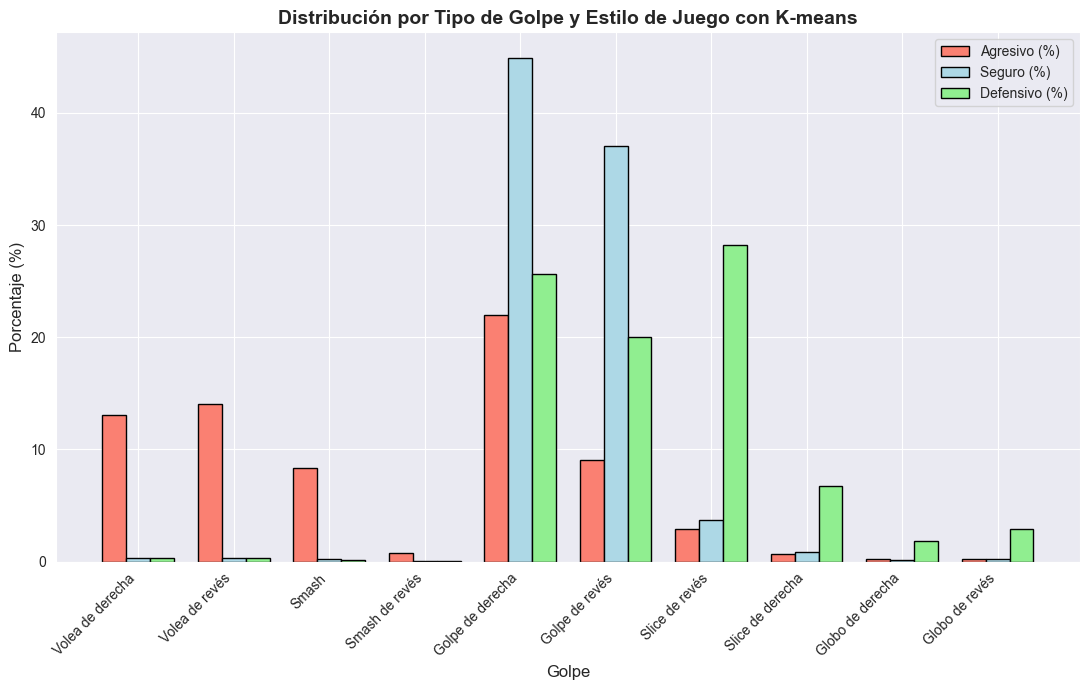

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# Definir las columnas y los datos
characters = char_counts_df['Character']
aggressive = char_counts_df['Count_aggressive_pct']
safe = char_counts_df['Count_safe_pct']
defensive = char_counts_df['Count_defensive_pct']

# Configurar la posición de las barras
x = np.arange(len(characters))  # Posiciones de las barras para cada categoría
width = 0.25  # Ancho de cada barra

# Crear el gráfico de barras agrupadas con bordes negros
fig, ax = plt.subplots(figsize=(11, 7))
ax.bar(x - width, aggressive, width, label='Agresivo (%)', color='salmon', edgecolor='black')
ax.bar(x, safe, width, label='Seguro (%)', color='lightblue', edgecolor='black')
ax.bar(x + width, defensive, width, label='Defensivo (%)', color='lightgreen', edgecolor='black')

# Añadir etiquetas y título
ax.set_xlabel('Golpe', fontsize=12)
ax.set_ylabel('Porcentaje (%)', fontsize=12)
ax.set_title('Distribución por Tipo de Golpe y Estilo de Juego con K-means', fontsize=14, fontweight='bold')  # Título en negrita
ax.set_xticks(x)
ax.set_xticklabels(characters, rotation=45, ha='right', fontsize=10)
ax.legend()

# Ajustar diseño
plt.tight_layout()

plt.savefig('viz_outputs/conteo_golpes_por_cluster.png')
# Mostrar el gráfico
plt.show()
